In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, converters
from numpy import pi
from math import floor, log2


In [2]:
N = 15 # Number we want to factor
L = 3  # Number of bits needed to represent N
epsilon = .02 # todo idk what this is
t = 2*L + 1 + floor(1 + log2(2 + 1/(2*epsilon)))  # formula from nielsen for required qbits
print(t)

12


In [16]:
# blatantly stole qft circuit generator from this:
# https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform

# stolen from https://quantumcomputing.stackexchange.com/questions/29647/trying-to-construct-modular-exponentiation-gate-in-qiskit
# todo need to actually implement something.
# Basically, fix N (number to factor) and create modexp gate based on that.
# lucky me this code is for 15 lol ggez
# fixme uhh control
def c_amod15_gate(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "y * %i^%i mod 15" % (a, power)

    # I guess you need to apply control more?
    c_U = U.control()
    return c_U

def modexp(circuit, n):
   pass

def modexp_gate(n):
  qc = QuantumCircuit(n)
  qc.name = "QFT"
  modexp(qc, n)
  gate = converters.circuit_to_gate(qc)

  return gate


In [37]:
circ = QuantumCircuit(5)
gate = c_amod15_gate(4, 2)
circ.x(0)
circ.x(1) #lsb
#[circ.x(i) for i in range(1, 5)]
circ.append(gate, range(0, 5))
circ.measure_all()
circ.draw()

┌───┐                    ░ ┌─┐            
   q_0: ┤ X ├─────────■──────────░─┤M├────────────
        ├───┤┌────────┴────────┐ ░ └╥┘┌─┐         
   q_1: ┤ X ├┤0                ├─░──╫─┤M├─────────
        └───┘│                 │ ░  ║ └╥┘┌─┐      
   q_2: ─────┤1                ├─░──╫──╫─┤M├──────
             │  y * 4^2 mod 15 │ ░  ║  ║ └╥┘┌─┐   
   q_3: ─────┤2                ├─░──╫──╫──╫─┤M├───
             │                 │ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ─────┤3                ├─░──╫──╫──╫──╫─┤M├
             └─────────────────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/════════════════════════════╩══╩══╩══╩══╩═
                                    0  1  2  3  4

In [30]:
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city

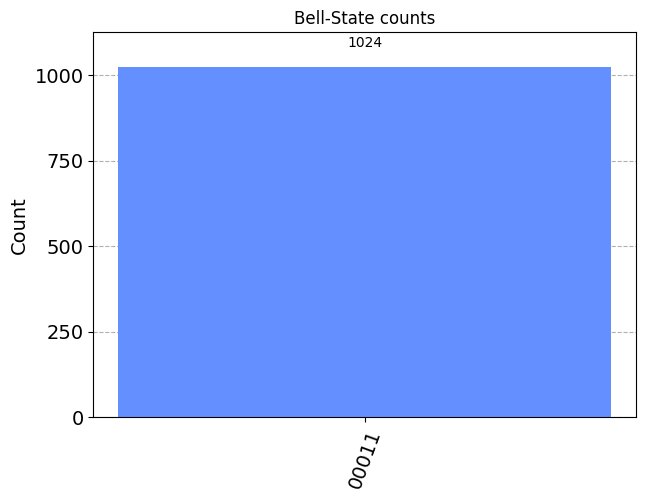

In [38]:
simulator = Aer.get_backend('aer_simulator')
transpiled_circ = transpile(circ, simulator)
result = simulator.run(transpiled_circ).result()
counts = result.get_counts(transpiled_circ)
plot_histogram(counts, title='Bell-State counts')
# ignore number on right i dont know how to do this without measure_all

In [ ]:
# ok, This appears to work
